In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score,GridSearchCV

from sklearn import ensemble
import xgboost
import sys
import warnings
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


import os 
print(os.listdir("../data")) # this will list files in input directory

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv']


# Load Data

In [14]:
raw_train=pd.read_csv('../data/train.csv')
raw_test=pd.read_csv('../data/test.csv')

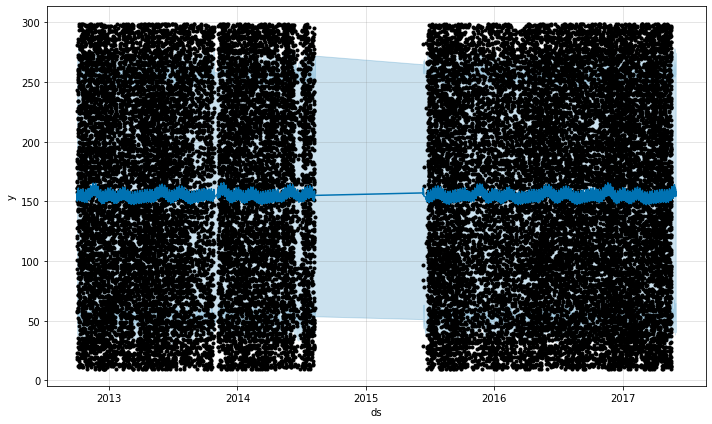

In [45]:
from fbprophet import Prophet
df = pd.read_csv('../data/train.csv')
df['ds']=df['date_time']
df['y']=df['air_pollution_index']
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

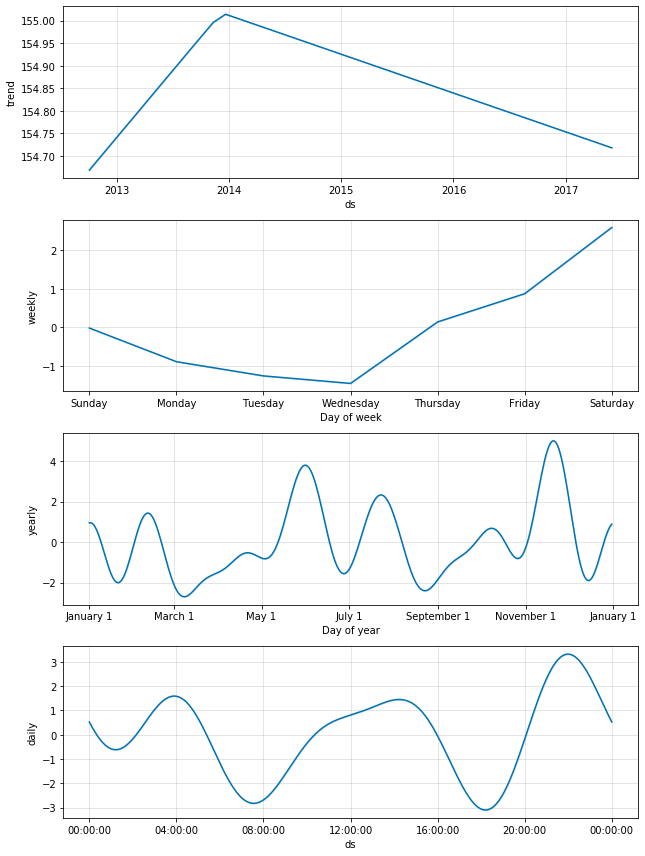

In [46]:
fig = m.plot_components(fcst)

In [15]:
raw_train.info() # So, there are some null in Age, Cabin and Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 14 columns):
date_time              33750 non-null object
is_holiday             33750 non-null object
humidity               33750 non-null int64
wind_speed             33750 non-null int64
wind_direction         33750 non-null int64
visibility_in_miles    33750 non-null int64
dew_point              33750 non-null int64
temperature            33750 non-null float64
rain_p_h               33750 non-null float64
snow_p_h               33750 non-null float64
clouds_all             33750 non-null int64
weather_type           33750 non-null object
air_pollution_index    33750 non-null int64
traffic_volume         33750 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 3.6+ MB


In [16]:
raw_train.tail(1)

,date_time,is_holiday,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,air_pollution_index,traffic_volume
33749,2017-05-17 23:00:00,None,63,1,27,8,8,285.75,0.0,0.0,90,Mist,140,1328


In [17]:
raw_test.info() # nulls in Age, Cabin and embarked ( same as train data), here in Fare Also

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14454 entries, 0 to 14453
Data columns (total 13 columns):
date_time              14454 non-null object
is_holiday             14454 non-null object
humidity               14454 non-null int64
wind_speed             14454 non-null int64
wind_direction         14454 non-null int64
visibility_in_miles    14454 non-null int64
dew_point              14454 non-null int64
temperature            14454 non-null float64
rain_p_h               14454 non-null float64
snow_p_h               14454 non-null int64
clouds_all             14454 non-null int64
weather_type           14454 non-null object
traffic_volume         14454 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 1.4+ MB


In [6]:
raw_test.tail(1)

,date_time,is_holiday,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,traffic_volume
14453,2018-09-30 23:00:00,None,70,8,328,6,6,282.12,0.0,0,90,Clouds,954


We are merging data together, so we can process data, after feature engineering we will split 

In [19]:
data=pd.concat([raw_train, raw_test], axis=0).reset_index(drop=True) # concatinating test and train removing index
data.tail(2) # column to be predicted will be NaN

,air_pollution_index,clouds_all,date_time,dew_point,humidity,is_holiday,rain_p_h,snow_p_h,temperature,traffic_volume,visibility_in_miles,weather_type,wind_direction,wind_speed
48202,NaN,90,2018-09-30 22:00:00,7,57,None,0.0,0.0,282.09,1450,7,Clouds,268,8
48203,NaN,90,2018-09-30 23:00:00,6,70,None,0.0,0.0,282.12,954,6,Clouds,328,8


In [20]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 14 columns):
air_pollution_index    33750 non-null float64
clouds_all             48204 non-null int64
date_time              48204 non-null object
dew_point              48204 non-null int64
humidity               48204 non-null int64
is_holiday             48204 non-null object
rain_p_h               48204 non-null float64
snow_p_h               48204 non-null float64
temperature            48204 non-null float64
traffic_volume         48204 non-null int64
visibility_in_miles    48204 non-null int64
weather_type           48204 non-null object
wind_direction         48204 non-null int64
wind_speed             48204 non-null int64
dtypes: float64(4), int64(7), object(3)
memory usage: 5.1+ MB


In [21]:
data.isnull().sum()  # finding null per column

air_pollution_index    14454
clouds_all             0    
date_time              0    
dew_point              0    
humidity               0    
is_holiday             0    
rain_p_h               0    
snow_p_h               0    
temperature            0    
traffic_volume         0    
visibility_in_miles    0    
weather_type           0    
wind_direction         0    
wind_speed             0    
dtype: int64

# Visualization & Data Cleaning

### Cabin

In [23]:
data["wind_speed"].value_counts()

2     9446
3     9282
4     7296
1     7064
5     5452
6     3592
7     2042
0     1711
8     1299
9     738 
10    167 
11    66  
12    24  
13    15  
15    5   
14    3   
16    2   
Name: wind_speed, dtype: int64

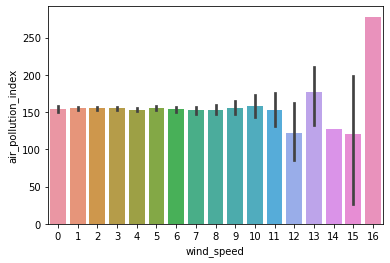

In [35]:
sns.barplot(x="wind_speed", y="air_pollution_index", data=raw_train)

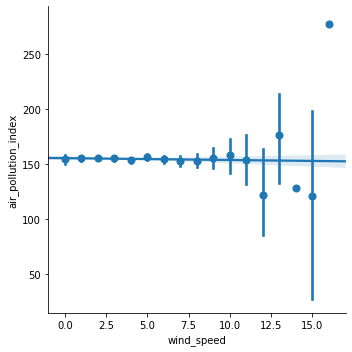

In [39]:
sns.lmplot(x="wind_speed", y="air_pollution_index", data=raw_train,x_estimator=np.mean) 


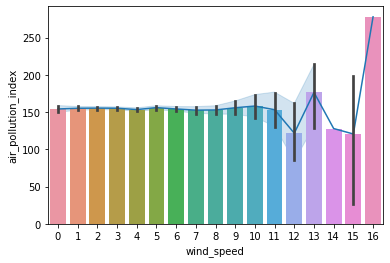

In [34]:
sns.lineplot(x="wind_speed", y="air_pollution_index", data=raw_train) 



### Embarked

In [ ]:
data['Embarked'].isnull().sum()

In [ ]:
data['Embarked'].value_counts() # embarked - from where, C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
data[data['Embarked'].isnull()]

In [ ]:
 sns.boxplot(x="Embarked", y="Fare", hue="Pclass",data=data) # relation between Embarked and Fare for each Class


In [ ]:
sns.barplot(x='Embarked',y="Survived",data=data)

In [ ]:
data['Embarked']=data['Embarked'].fillna('C')

### Fare

In [ ]:
data[data['Fare'].isnull()]

In [ ]:
fare=data[(data['Age'] >60) & (data['Embarked'] == "S") & (data['Pclass'] == 3)].Fare # find all fares matching condition
data['Fare']=data['Fare'].fillna(fare.median()) # find media and assign

In [ ]:
sns.kdeplot(data.loc[data['Survived'] == 0, 'Fare'], label='Died')
sns.kdeplot(data.loc[data['Survived'] == 1, 'Fare'], label='Survived')

### Name

In [ ]:
data.Name

In [ ]:
# Get Title from Name
data["Title"] = data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
data["Title"].value_counts()

In [ ]:
data["Title"] = data["Title"].replace(['Mlle','Ms'], 'Miss')
data["Title"] = data["Title"].replace(['Mme'], 'Mrs')
data["Title"] = data["Title"].replace(['Rev', 'Dr', 'Col', 'Major', 'Capt'], 'Officer')
data["Title"] = data["Title"].replace(['the Countess', 'Don', 'Lady', 'Sir', 'Jonkheer', 'Dona'], 'Royalty')
data["Title"].value_counts()

In [ ]:
sns.barplot(x="Title", y="Survived", data=data)

### Parch & SibSp

In [ ]:
# Create a family size descriptor from SibSp and Parch
data["Fsize"] = data["SibSp"] + data["Parch"] + 1
sns.factorplot(x="Fsize",y="Survived",data = data)

In [ ]:
# Create new feature of family size
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
data['FamilyLabel']=data['Fsize'].apply(Fam_label)

In [ ]:
sns.barplot(x="FamilyLabel", y="Survived", data=data)

### Pclass

In [ ]:
sns.barplot(x="Pclass", y="Survived", data=data)

### Sex

In [ ]:
sns.barplot(x="Sex", y="Survived", data=data)

### Ticket

In [ ]:
data['Ticket'].value_counts() # ticket sale per ticket type from 1 to 11

In [ ]:
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].apply(lambda x:Ticket_Count[x])
data['TicketGroup'].value_counts() # group ticket by count of sales

In [ ]:
sns.barplot(x='TicketGroup', y='Survived', data=data)

In [ ]:
def Ticket_Label(s): # group all having same survival together
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

data['TicketGroup'] = data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=data)

### Age

In [ ]:
data.info()

In [ ]:
age_df = data[['Age', 'Pclass','Sex','Title','Fsize']]

# get_dummies() only works on strings, and convert to one-hot encoding
# here it will only work on String columns ( Sex(male/female) and title)
age_df=pd.get_dummies(age_df) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
age_df.head()

In [ ]:
age_df[age_df.Age.notnull()].as_matrix()# converts df into 2d matrix/ as below

In [ ]:
known_age = age_df[age_df.Age.notnull()].as_matrix() # Rows with known age
unknown_age = age_df[age_df.Age.isnull()].as_matrix() # Rows with unknown age
y = known_age[:, 0] # age columns
X = known_age[:, 1:] # all other columns
X

In [ ]:
#predicting ages for unknown using XGBoost
rfr=xgboost.XGBClassifier()
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
predictedAges[:10]

In [ ]:
data.loc[(data.Age.isnull()), 'Age' ] = predictedAges #put predicted ages where it was null
data.head()

# Modeling

In [ ]:
data.info()

In [ ]:
data.head(1)

In [ ]:
#choosing required columns and converting to 0/1 for strings
data=data[['Survived','Age','Cabin','Embarked','Fare','Pclass','Sex','TicketGroup','FamilyLabel','Title']]
data=pd.get_dummies(data)
data.head()

In [ ]:
data.tail()

In [ ]:
data.info()

In [ ]:
train=data[:len(raw_train)] # take train data
test=data[len(raw_train):].drop(['Survived'],axis=1) # take test data
x = train.drop(['Survived'],axis=1)
y = train.Survived

In [ ]:
model = ensemble.RandomForestClassifier(random_state = 10, 
                                      warm_start = True,
                                      n_estimators = 26, 
                                      max_depth = 6, 
                                      max_features = 'sqrt')
model.fit(x,y)

In [ ]:
predictions = model.predict(test)
submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"],
                           "Survived": predictions.astype(np.int32)})
submission.to_csv("../ouput/output.csv", index=False)
